In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

from cartopy.crs import PlateCarree
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes

from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import matplotlib.ticker as mticker
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize

from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

from scipy.optimize import curve_fit
from scipy.stats import skewnorm, weibull_min, exponweib

import warnings
warnings.filterwarnings("ignore")

from basic_functions import * 

In [2]:
chlorophyll = xr.open_dataset("../data/SCS/MODIS_chl_extended.nc").chlor_a
temperature = xr.open_dataset("../data/SCS/CMEMS_temp_extended.nc").analysed_sst

bathy = xr.open_dataset("../data/SCS/bathymetry_interpolated.nc")

bathymetry_coast = bathy.where((bathy.elevation >= -1000)).elevation.to_numpy()

lons, lats = chlorophyll.lon, chlorophyll.lat

# Data clustering

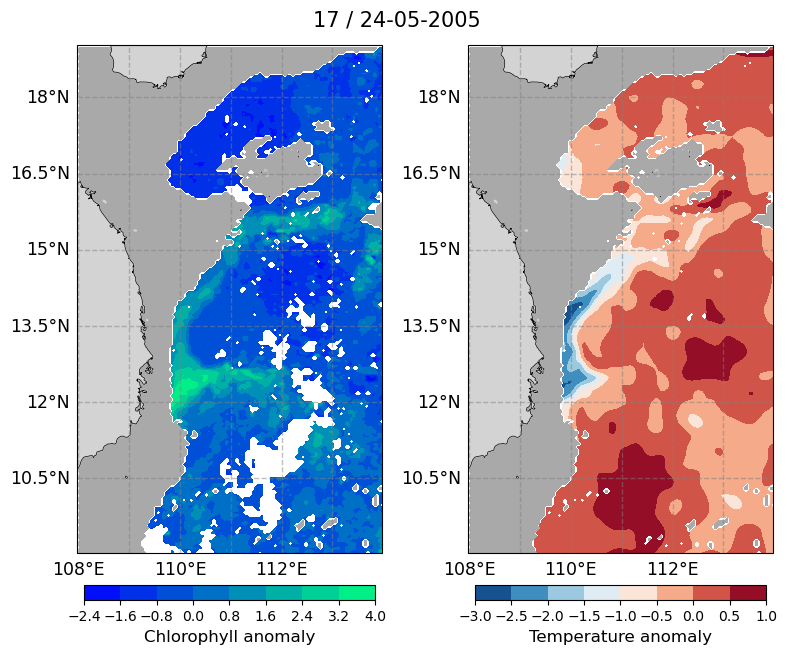

In [4]:
start_date = date(2005,5, 17)
end_date = date(2005,5,25)

chl = find_mean(chlorophyll, start_date, end_date)
chl_clima, chl_std = clima_std(chlorophyll, start_date, end_date)

temp = find_mean(temperature, start_date, end_date)
temp_clima, temp_std = clima_std(temperature,  start_date, end_date)

fig, ax = set_plot(ncols= 2, figsize = [8,7])
ax = define_coast(ax, lons, lats, bathymetry_coast)


c = ax[0].contourf(lons, lats, bathymetry_filter((chl - chl_clima) / chl_std, bathy), cmap = "winter")
#ax[0].contourf(lons, lats, bathymetry_coast, colors = "darkgray", zorder = -1)

cb = plt.colorbar(c, ax = ax[0], orientation = "horizontal", pad = 0.05, shrink = 0.9)
cb.set_label("Chlorophyll anomaly", fontsize = 12)

c = ax[1].contourf(lons, lats, bathymetry_filter((temp - temp_clima) / temp_std, bathy), cmap = "RdBu_r")
#ax[1].contourf(lons, lats, bathymetry_coast, colors = "darkgray", zorder = -1)
cb = plt.colorbar(c, ax = ax[1], orientation = "horizontal", pad = 0.05, shrink = 0.9)
cb.set_label("Temperature anomaly", fontsize = 12)

fig.suptitle("%s / %s" %(start_date.strftime("%d"), (end_date - timedelta(days = 1)).strftime("%d-%m-%Y")), fontsize = 15)

fig.tight_layout()

plt.savefig("../immagini/SCS/CLUSTERING_EXAMPLES/%s_%s.pdf" %(start_date.strftime("%d"), (end_date - timedelta(days = 1)).strftime("%d-%m-%Y")))

In [5]:
chl_anomalies = bathymetry_filter((chl - chl_clima) / chl_std, bathy)
temp_anomalies = bathymetry_filter((temp - temp_clima) / temp_std, bathy)


cluster_data = prepare_clustering(chl_anomalies, temp_anomalies)

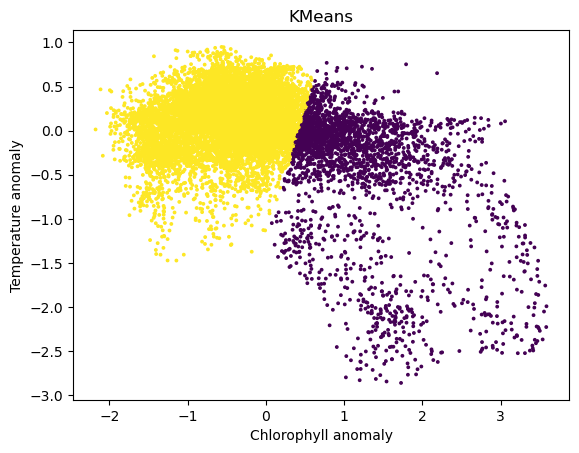

In [6]:
eps = 0.35
min_samples = 1000

#labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(cluster_data)
labels = KMeans(n_clusters = 2).fit_predict(cluster_data)

plt.scatter(cluster_data[:,0], cluster_data[:,1], s = 3, c = labels)
plt.xlabel("Chlorophyll anomaly")
plt.ylabel("Temperature anomaly")

#plt.title("DBSCAN \t $\epsilon$ = %s \t $M$ = %s"%(eps, min_samples))
plt.title("KMeans")

#plt.savefig("../immagini/SCS/DBSCAN_example.pdf")
plt.savefig("../immagini/SCS/KMeans_example.pdf")

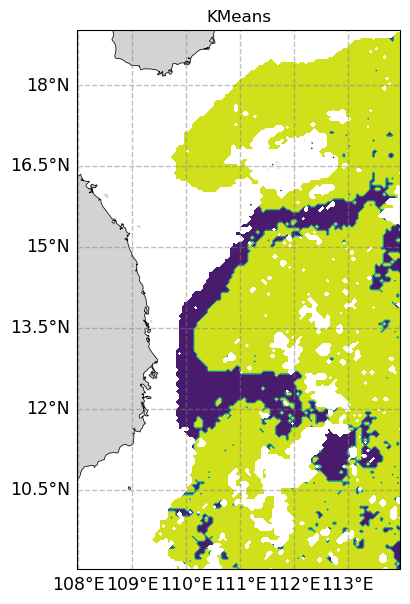

In [7]:
mask = ~np.isnan(chl_anomalies)

labels_proj = labels_matrix(labels, mask)

fig, ax = set_plot()
ax.contourf(lons, lats, labels_proj, transform = PlateCarree())
ax.set_title("KMeans")
#ax.set_title("DBSCAN \t $\epsilon$ = %s \t $M$ = %s"%(eps, min_samples))

plt.savefig("../immagini/SCS/KMeans_example2.pdf")
#plt.savefig("../immagini/SCS/DBSCAN_example2.pdf")

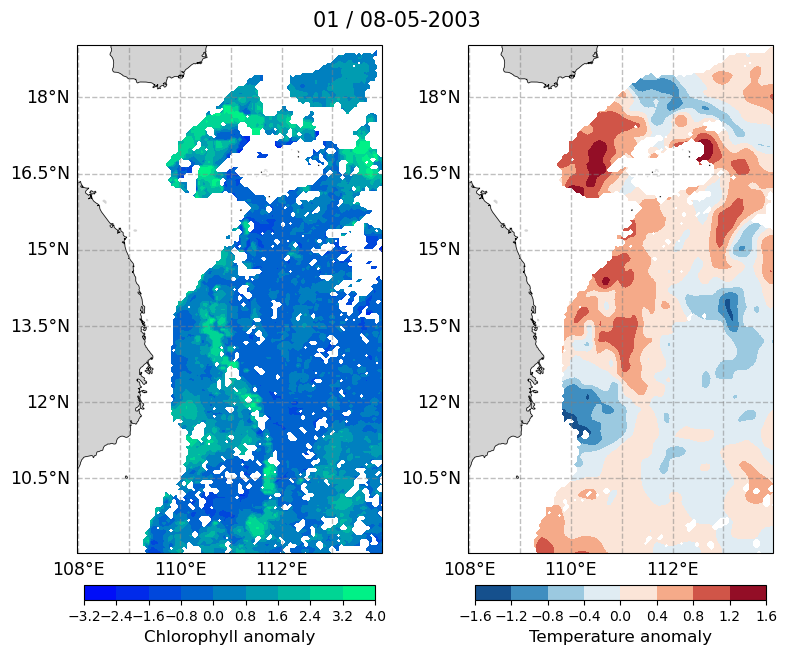

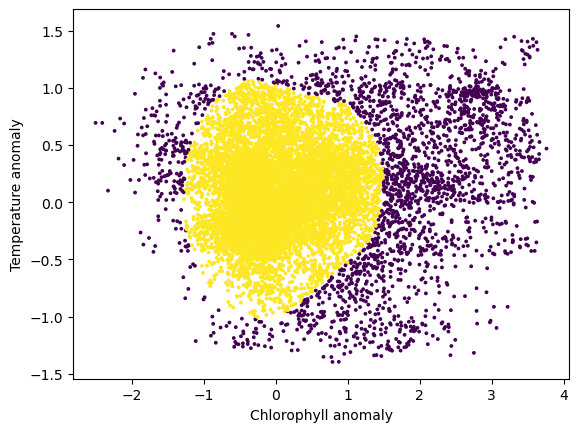

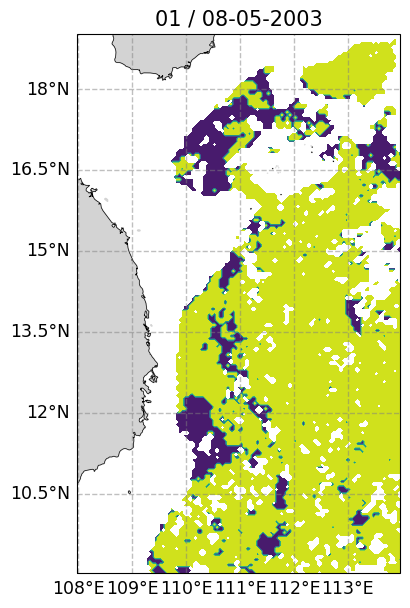

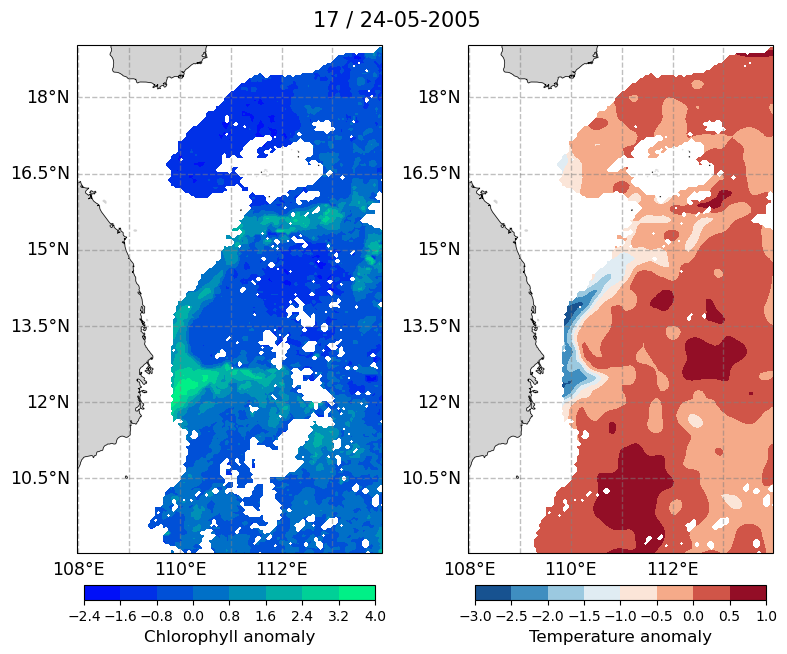

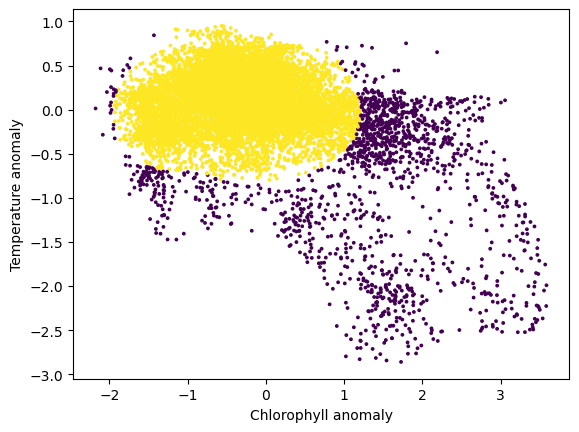

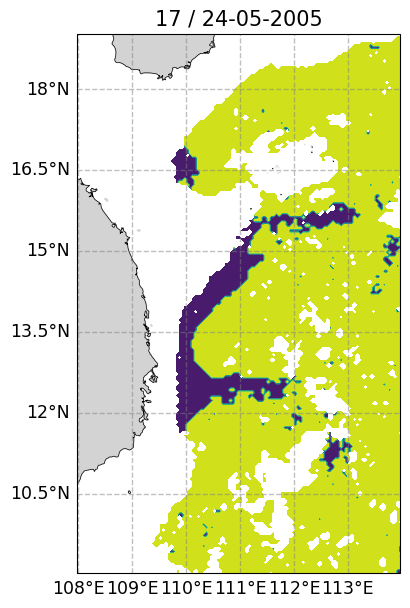

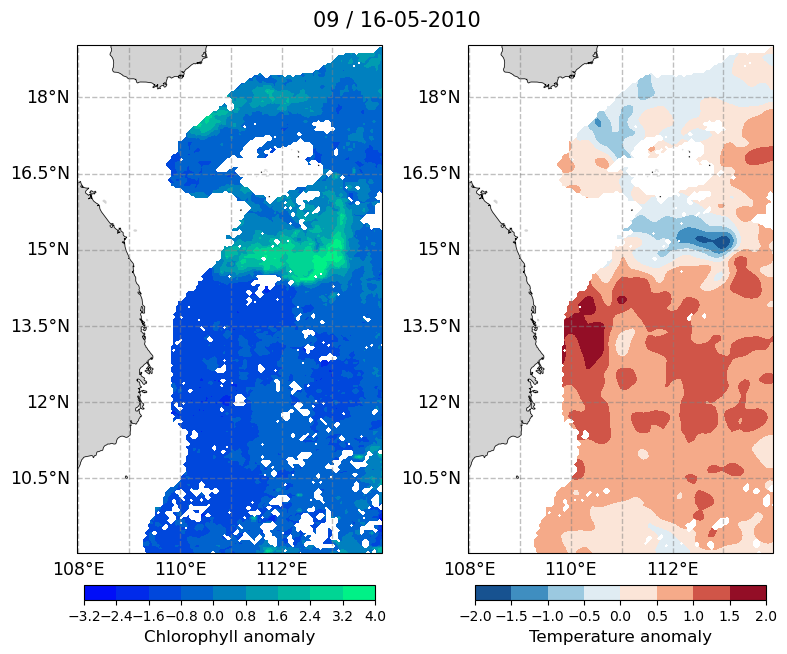

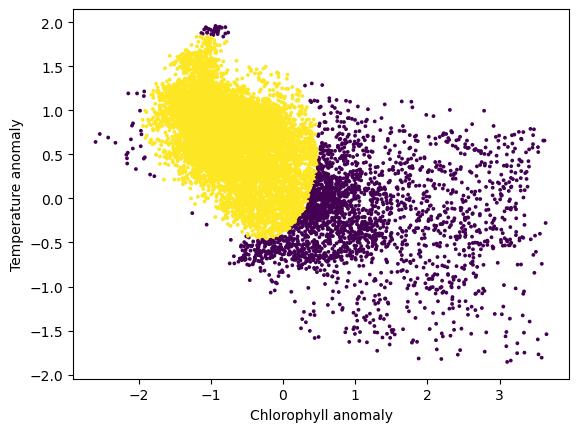

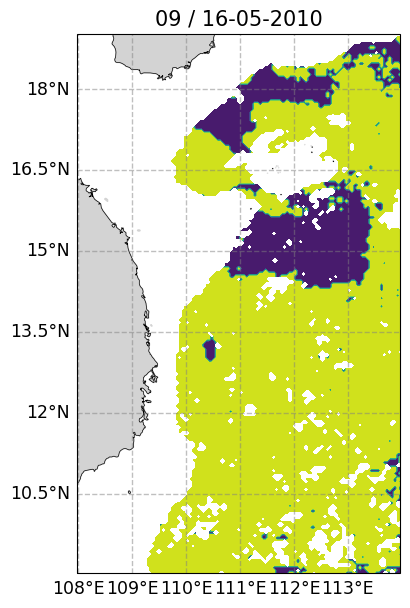

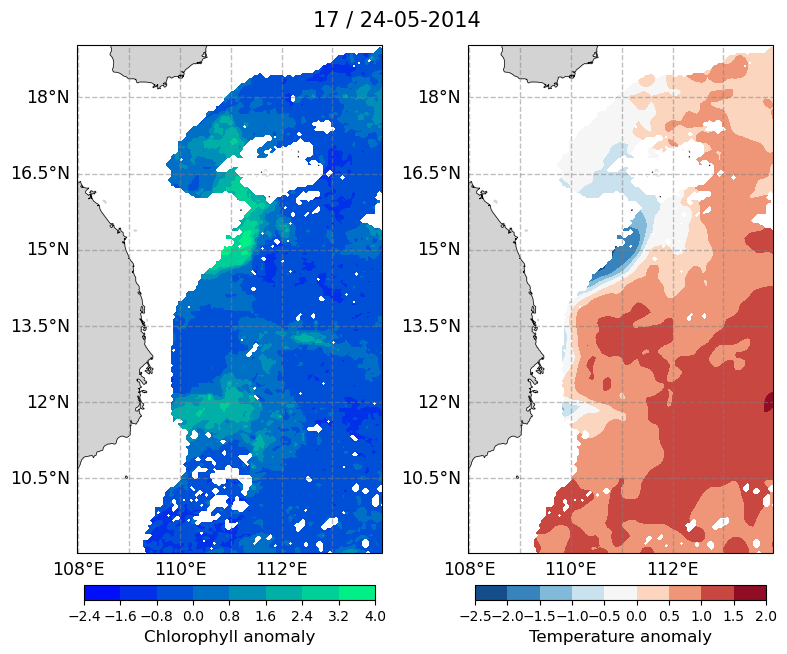

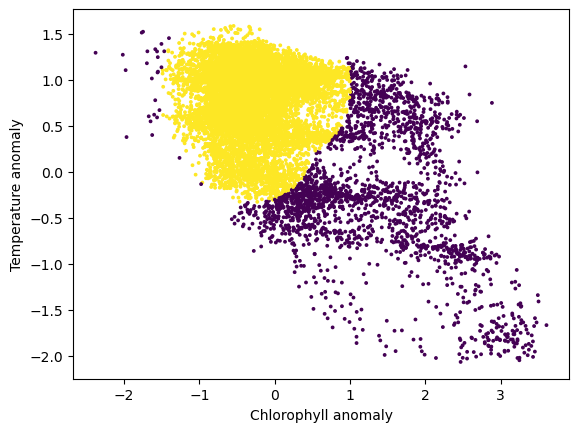

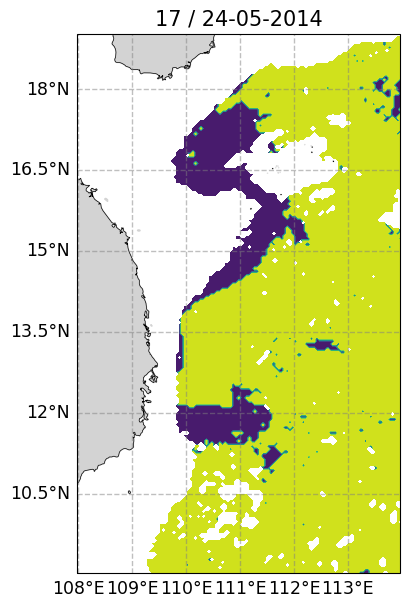

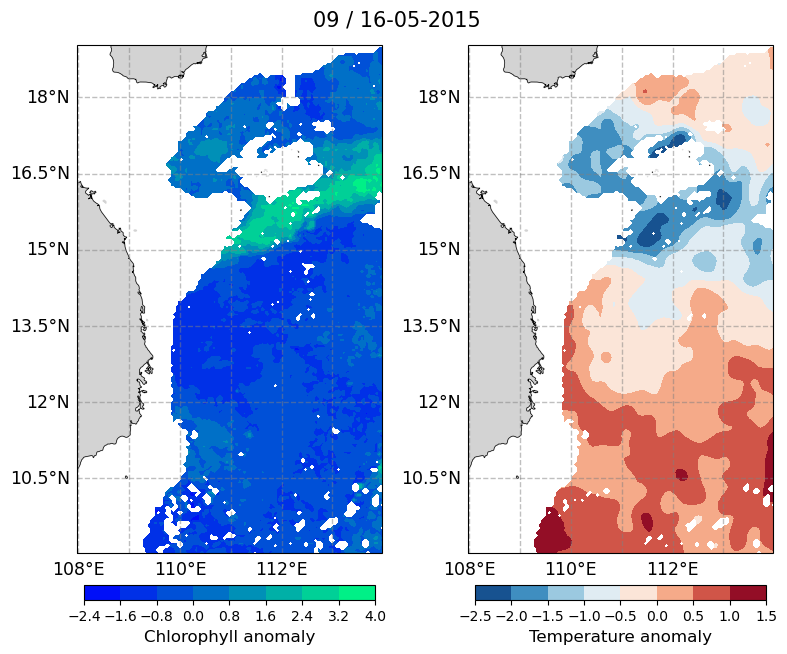

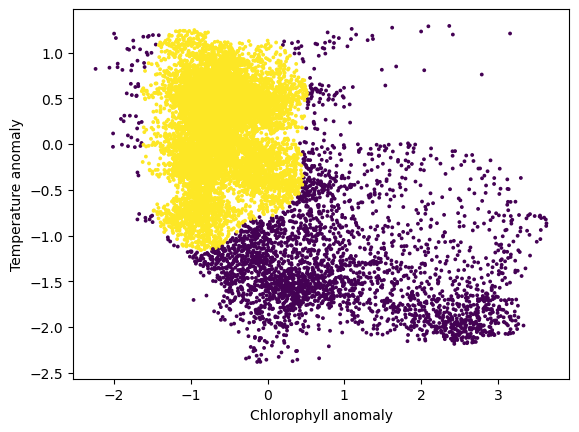

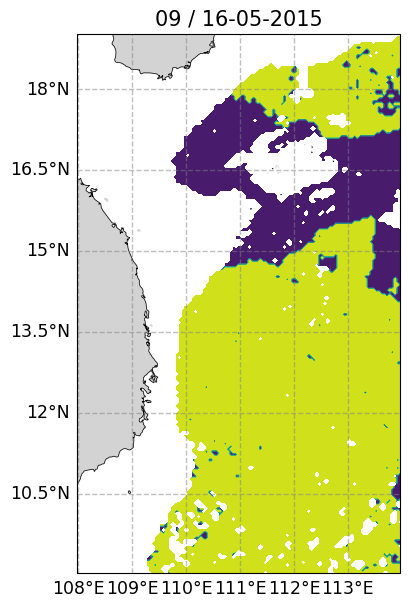

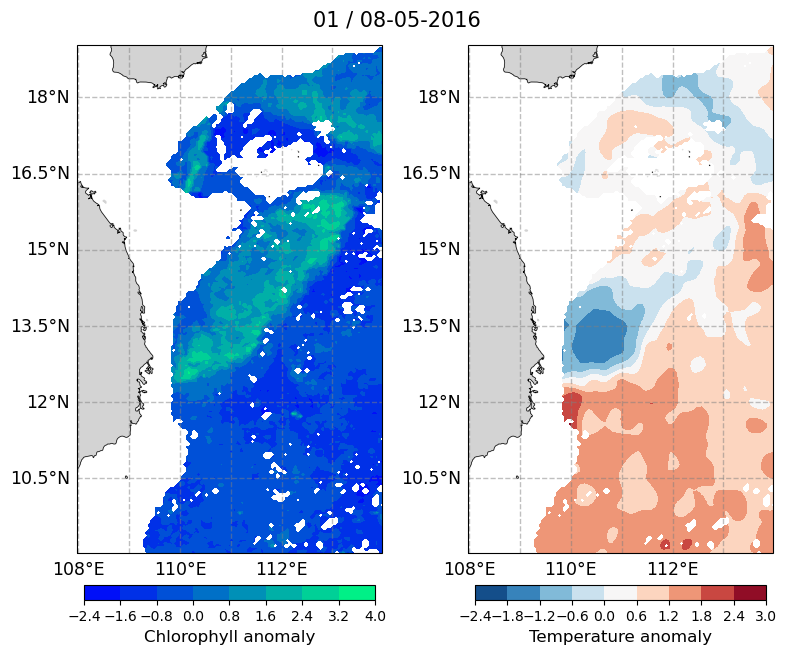

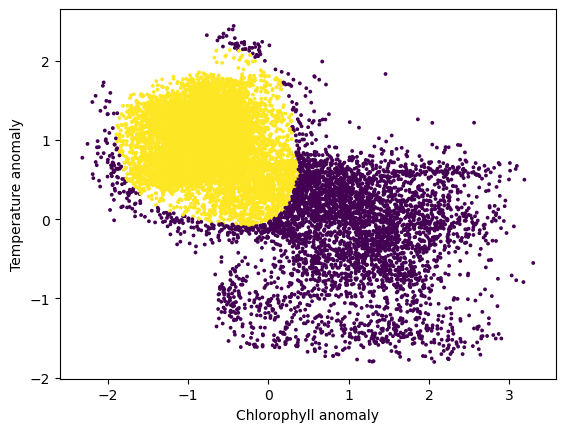

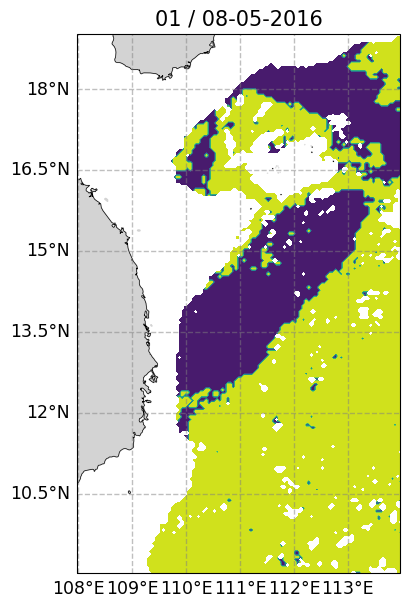

In [8]:
start_list = [date(2003,5,1), date(2005,5,17), date(2010, 5, 9), date(2014,5,17), date(2015,5,9), date(2016,5,1)]

end_list = [date(2003,5,9), date(2005,5,25), date(2010, 5, 17), date(2014,5,25), date(2015,5,17), date(2016,5,9)]

for s, e in zip(start_list, end_list):

    start_date = s
    end_date = e

    chl = find_mean(chlorophyll, start_date, end_date)
    chl_clima, chl_std = clima_std(chlorophyll, start_date, end_date)

    temp = find_mean(temperature, start_date, end_date)
    temp_clima, temp_std = clima_std(temperature,  start_date, end_date)

    fig, ax = set_plot(ncols= 2, figsize = [8,7])

    c = ax[0].contourf(lons, lats, bathymetry_filter((chl - chl_clima) / chl_std, bathy), cmap = "winter")
    cb = plt.colorbar(c, ax = ax[0], orientation = "horizontal", pad = 0.05, shrink = 0.9)
    cb.set_label("Chlorophyll anomaly", fontsize = 12)

    c = ax[1].contourf(lons, lats, bathymetry_filter((temp - temp_clima) / temp_std, bathy), cmap = "RdBu_r")
    cb = plt.colorbar(c, ax = ax[1], orientation = "horizontal", pad = 0.05, shrink = 0.9)
    cb.set_label("Temperature anomaly", fontsize = 12)


    fig.suptitle("%s / %s" %(start_date.strftime("%d"), (end_date - timedelta(days = 1)).strftime("%d-%m-%Y")), fontsize = 15)

    fig.tight_layout()

    plt.savefig("../immagini/SCS/CLUSTERING_EXAMPLES/%s_%s.pdf" %(start_date.strftime("%d"), (end_date - timedelta(days = 1)).strftime("%d-%m-%Y")))

    ################################

    chl_anomalies = bathymetry_filter((chl - chl_clima) / chl_std, bathy)
    temp_anomalies = bathymetry_filter((temp - temp_clima) / temp_std, bathy)


    cluster_data = prepare_clustering(chl_anomalies, temp_anomalies)

    labels = DBSCAN(eps=0.4, min_samples=1000).fit_predict(cluster_data)
    
    fig = plt.figure()
    plt.scatter(cluster_data[:,0], cluster_data[:,1], s = 3, c = labels)
    plt.xlabel("Chlorophyll anomaly")
    plt.ylabel("Temperature anomaly")
    plt.savefig("../immagini/SCS/CLUSTERING_EXAMPLES/%s_%s_scatter.pdf" %(start_date.strftime("%d"), (end_date - timedelta(days = 1)).strftime("%d-%m-%Y")))

    ###############################

    mask = ~np.isnan(chl_anomalies)

    labels_proj = labels_matrix(labels, mask)

    fig, ax = set_plot()
    ax.contourf(lons, lats, labels_proj, transform = PlateCarree())

    ax.set_title("%s / %s" %(start_date.strftime("%d"), (end_date - timedelta(days = 1)).strftime("%d-%m-%Y")), fontsize = 15)
    plt.savefig("../immagini/SCS/CLUSTERING_EXAMPLES/%s_%s_clustered.pdf" %(start_date.strftime("%d"), (end_date - timedelta(days = 1)).strftime("%d-%m-%Y")),
                bbox_inches = "tight")



# Elbow distribution and usage of KMeans

In [40]:
start_date = date(2005,5,17)
end_date = date(2005,5,25)

chl = find_mean(chlorophyll, start_date, end_date)
chl_clima, chl_std = clima_std(chlorophyll, start_date, end_date)

temp = find_mean(temperature, start_date, end_date)
temp_clima, temp_std = clima_std(temperature,  start_date, end_date)

chl_anomalies = bathymetry_filter((chl - chl_clima) / chl_std, bathy)
temp_anomalies = bathymetry_filter((temp - temp_clima) / temp_std, bathy)

cluster_data = prepare_clustering(chl_anomalies, temp_anomalies)

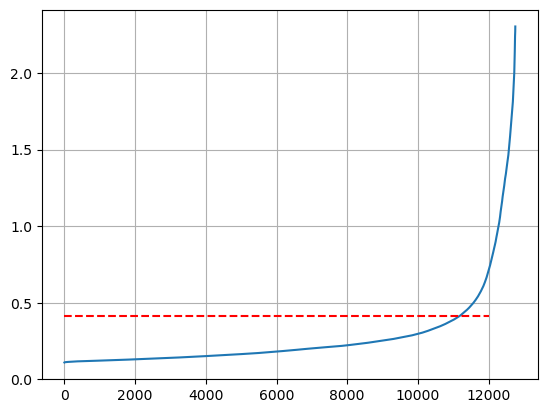

In [45]:
n_n = 1000
nn = NearestNeighbors(n_neighbors=n_n+1).fit(cluster_data)
distances, indices = nn.kneighbors(cluster_data)

distances = np.sort(distances, axis=0)[:,1:]
# distances = distances[:,n_n-1]
distances = distances.mean(axis = 1)

eps = KneeLocator(np.arange(0,len(distances)), distances, S=1.0, curve="convex", direction="increasing").elbow_y

plt.plot(distances)
plt.hlines(eps, xmin = 0, xmax = 12000, linestyles="--", colors = "red")
#plt.xlim([10500,13000])
plt.grid()

Text(0, 0.5, 'Temperature anomaly')

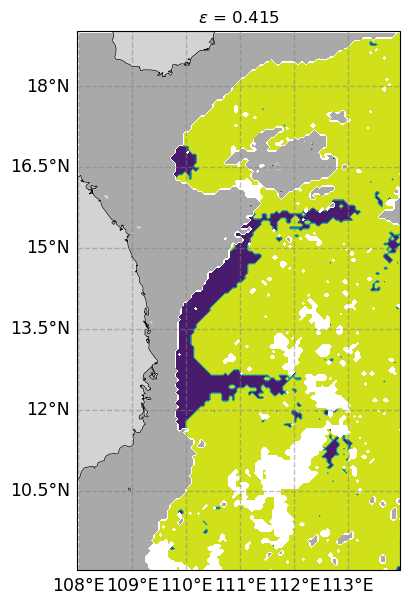

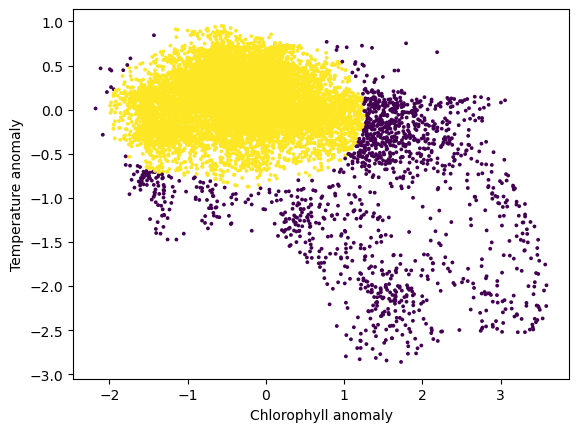

In [46]:
mask = ~np.isnan(chl_anomalies)

labels = DBSCAN(eps=eps, min_samples=n_n).fit_predict(cluster_data)

labels_proj = labels_matrix(labels, mask)

fig, ax = set_plot()
#ax = define_coast(ax, lons, lats, bathymetry_coast)
ax.contourf(lons, lats, labels_proj, transform = PlateCarree())
ax.contourf(lons, lats, bathymetry_coast, colors = "darkgray", zorder = -1)
ax.set_title("$\epsilon$ = %.3f"%(eps))

fig = plt.figure()
plt.scatter(cluster_data[:,0], cluster_data[:,1], s = 3, c = labels)
plt.xlabel("Chlorophyll anomaly")
plt.ylabel("Temperature anomaly")

array([-1,  0], dtype=int64)

In [ ]:
elbow = []
for nc in range(2,50):
    elbow.append(KMeans(n_clusters = nc).fit(cluster_data).inertia_)

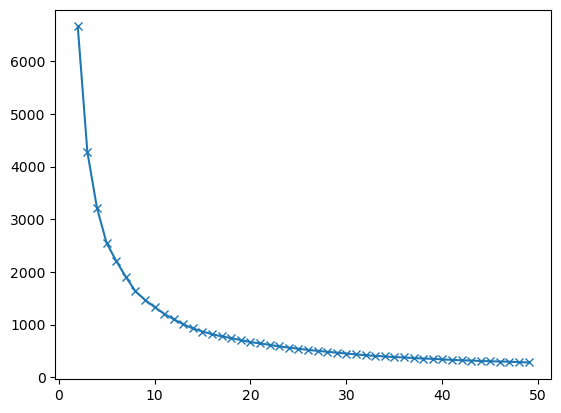

In [ ]:
plt.figure()

plt.plot(np.arange(2,50), elbow, marker = "x")

Text(0, 0.5, 'Temperature anomaly')

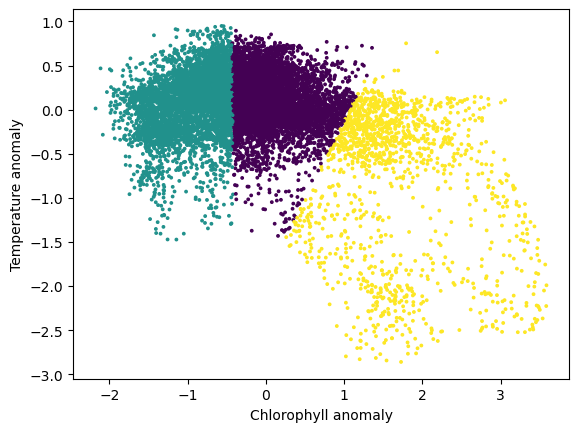

In [ ]:
labels = KMeans(n_clusters=3).fit_predict(cluster_data)

fig = plt.figure()
plt.scatter(cluster_data[:,0], cluster_data[:,1], s = 3, c = labels)
plt.xlabel("Chlorophyll anomaly")
plt.ylabel("Temperature anomaly")

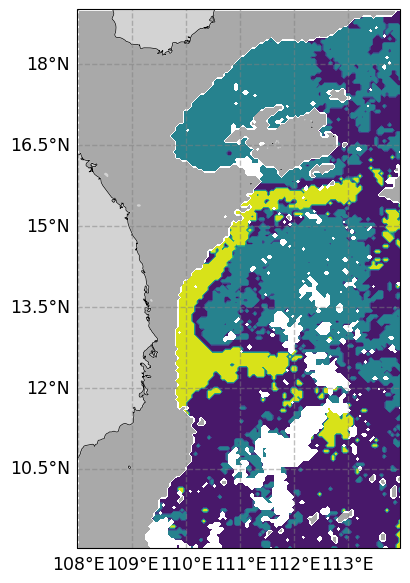

In [ ]:
mask = ~np.isnan(chl_anomalies)

labels_proj = labels_matrix(labels, mask)

fig, ax = set_plot()
#ax = define_coast(ax, lons, lats, bathymetry_coast)
ax.contourf(lons, lats, labels_proj, transform = PlateCarree())
ax.contourf(lons, lats, bathymetry_coast, colors = "darkgray", zorder = -1)


# Images database for filament analysis (spring)

In [ ]:
for year in range(2003, 2019):

    for month in range(3, 6):

        for day in range(1, 25, 8):

            start_date = date(year,month,day)
            end_date = date(year,month,day+8)
            
            chl = find_mean(chlorophyll, start_date, end_date)
            chl_clima, chl_std = clima_std(chlorophyll, start_date, end_date)

            fig, ax = set_plot()

            ax.set_title("%s / %s" %(start_date.strftime("%d"), date(year,month,day+7).strftime("%d-%m-%Y")), fontsize = 15)

            c = ax.contourf(lons, lats, bathymetry_filter((chl - chl_clima) / chl_std, bathy), cmap = "winter")
            plt.colorbar(c, ax = ax)

            plt.savefig("../immagini/SCS/IMAGES_DATABASE/%s_%s.png"%(start_date.strftime("%Y%m%d"), date(year,month,day+7).strftime("%Y%m%d")), bbox_inches = "tight")
            plt.ioff()


# Skew-normal per anomalie

In [ ]:
start_date = date(2016,5,1)
end_date = date(2016,5,9)

chl = find_mean(chlorophyll, start_date, end_date)
chl_clima, chl_std = clima_std(chlorophyll, start_date, end_date)

chl_anomalies = bathymetry_filter(chl - chl_clima, bathy)

chl_anomalies = chl_anomalies[~np.isnan(chl_anomalies)]

plt.figure()
bin_heights, bin_borders, _ = plt.hist(chl_anomalies.flatten(), bins = 25, density= True, label = "Data", alpha = 0.7)

xmin, xmax = plt.xlim()

x = np.linspace(xmin, xmax, 100)
fit = skewnorm.fit(chl_anomalies)
plt.plot(x, skewnorm.pdf(x, *fit), label = "Fit", color = "red", linewidth = 2)
plt.grid()
plt.legend()
plt.xlabel("Chlorophyll anomaly from climatology [mg/m$^3$]")
plt.ylabel("Density")

textstr = '\n'.join((
    'skewness = %.2f' % (fit[0], ),
    'loc = %.2f' % (fit[1], ),
    'scale = %.2f' % (fit[2], )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.75, 0.6), xycoords='axes fraction')
    
plt.title("Chlorophyll anomalies distribution - %s / %s"%(start_date.strftime("%d"), (start_date + timedelta(days = 7)).strftime("%d-%m-%Y")))
plt.savefig("../immagini/SCS/anomaly_fit_%s_%s.pdf"%(start_date.strftime("%d"), (start_date + timedelta(days = 7)).strftime("%d-%m-%Y")), 
bbox_inches = "tight")

# Time series of chlorophyll in selected regions

In [ ]:
chlorophyll = xr.open_dataset("../data/SCS/MODIS_chl_extended_8D.nc").chlor_a

In [ ]:
lon_min = 112.025
lon_max = 112.025
lat_min = 10.
lat_max = 15.

fig, ax = plot_histogram(chlorophyll, [lon_min, lon_max], [lat_min, lat_max], region = True)

ax.set_title("Chlorophyll time series (01/01/2003 - 31/12/2021) \n All the values in the region \n lon = %s°E, lat = %s°N"%(lon_min, [lat_min, lat_max]))
ax.set_xlabel("Chlorophyll concentration [mg/m$^3$]")

plt.savefig("../immagini/SCS/anomaly_fit_LINE.pdf", bbox_inches = "tight")


fig, ax = plot_time_series(chlorophyll, [lon_min, lon_max], [lat_min, lat_max], region = True)
ax.set_title("Chlorophyll time series (01/01/2003 - 31/12/2021) \
             \n Averaged values in the region \n lon = %s°E, lat = %s°N"%(lon_min, [lat_min, lat_max]))
ax.set_ylabel("Chlorophyll concentration [mg/m$^3$]")

plt.savefig("../immagini/SCS/time_series_LINE.pdf", bbox_inches = "tight")


In [ ]:
lon_min = 112.025
lat_min = 12.225

fig, ax = plot_histogram(chlorophyll, lon_min, lat_min, point = True, region = False)

ax.set_title("Chlorophyll time series (01/01/2003 - 31/12/2021) \n lon = %s°E, lat = %s°N"%(lon_min, lat_min))
ax.set_xlabel("Chlorophyll concentration [mg/m$^3$]")

plt.savefig("../immagini/SCS/anomaly_fit_POINT_%s_%s.pdf"%(lon_min, lat_min), bbox_inches = "tight")

fig, ax = plot_time_series(chlorophyll, lon_min, lat_min, point = True, region = False)

ax.set_title("Chlorophyll time series (01/01/2003 - 31/12/2021) \n lon = %s°E, lat = %s°N"%(lon_min, lat_min))
ax.set_ylabel("Chlorophyll concentration [mg/m$^3$]")

plt.savefig("../immagini/SCS/time_series_POINT_%s_%s.pdf"%(lon_min, lat_min), bbox_inches = "tight")

# Study of time anomalies

In [47]:
chlorophyll = xr.open_dataset("../data/SCS/MODIS_chl_extended_8D.nc").chlor_a

In [48]:
chlorophyll = chlorophyll.assign_coords(day_of_year = chlorophyll.time.dt.strftime("%d-%m"))
chl_anomalies = ((chlorophyll.groupby("day_of_year") - chlorophyll.groupby("day_of_year").mean("time")).groupby("day_of_year")) / chlorophyll.groupby("day_of_year").std("time")

## Distributions

In [ ]:
lon_min = 112.025
lon_max = 112.025
lat_min = 10.
lat_max = 15.

fig, ax = plot_histogram(chl_anomalies, [lon_min, lon_max], [lat_min, lat_max], region = True, fit_func=skewnorm)

ax.set_title("Time series of the deviation from climatology (01/01/2003 - 31/12/2021) \n lon = %s°E, lat = %s°N"%(lon_min, [lat_min, lat_max]))
ax.set_xlabel("Deviation from climatology [mg/m$^3$]")
plt.savefig("../immagini/SCS/deviation_fit_LINE.pdf", bbox_inches = "tight")

fig, ax = plot_time_series(chl_anomalies, [lon_min, lon_max], [lat_min, lat_max], region = True)

ax.set_title("Time series of the deviation from climatology (01/01/2003 - 31/12/2021) \n Averaged values in the region \n lon = %s°E, lat = %s°N"%(lon_min, [lat_min, lat_max]))
ax.set_ylabel("Deviation from climatology [mg/m$^3$]")
plt.savefig("../immagini/SCS/deviation_timeseries_LINE.pdf", bbox_inches = "tight")

In [ ]:
mask_lon = (chl_anomalies.lon >= lon_min) & (chl_anomalies.lon <= lon_max)
mask_lat = (chl_anomalies.lat >= lat_min) & (chl_anomalies.lat <= lat_max)

time_series = chl_anomalies.where(mask_lon & mask_lat, drop = True)
ts = time_series.to_numpy().flatten()[~np.isnan(time_series.to_numpy().flatten())]

from scipy.stats import skew
skew(ts)


In [ ]:


plt.hist(ts, bins = "auto", density= True)

In [ ]:
chl_anomalies.mean(dim = ["lon", "lat"]).max()

In [ ]:
fig, ax = plot_time_series(chl_anomalies, [lon_min, lon_max], [lat_min, lat_max], region = True)

ax.set_title("Chlorophyll time series (01/01/2003 - 31/12/2021) \n lon = %s°E, lat = %s°N"%(lon_min, lat_min))
ax.set_ylabel("Chlorophyll concentration [mg/m$^3$]")

In [ ]:
fig, ax = plot_time_series(chl_anomalies, lon_min, lat_min, point = True, region = False)

ax.set_title("Chlorophyll time series (01/01/2003 - 31/12/2021) \n lon = %s°E, lat = %s°N"%(lon_min, lat_min))
ax.set_ylabel("Chlorophyll concentration [mg/m$^3$]")

#plt.savefig("../immagini/SCS/time_series_POINT_%s_%s.pdf"%(lon_min, lat_min), bbox_inches = "tight")



## Error of clustering algorithm

In [52]:
chlorophyll = xr.open_dataset("../data/SCS/MODIS_chl_extended_8D.nc").chlor_a
temperature = xr.open_dataset("../data/SCS/CMEMS_temp_extended_8D.nc").analysed_sst

chlorophyll = chlorophyll.assign_coords(day_of_year = chlorophyll.time.dt.strftime("%d-%m"))
chl_anomalies = ((chlorophyll.groupby("day_of_year") - chlorophyll.groupby("day_of_year").mean("time")).groupby("day_of_year")) / chlorophyll.groupby("day_of_year").std("time")

temperature = temperature.assign_coords(day_of_year = temperature.time.dt.strftime("%d-%m"))
temp_anomalies = ((temperature.groupby("day_of_year") - temperature.groupby("day_of_year").mean("time")).groupby("day_of_year")) / temperature.groupby("day_of_year").std("time")

In [66]:
minPts = 1000

err = []
eps_list = []

for (t, chl, temp) in zip(chl_anomalies.time.to_numpy(), chl_anomalies.to_numpy(), temp_anomalies.to_numpy()):

    chl, temp = bathymetry_filter(chl, bathy), bathymetry_filter(temp, bathy)

    im = prepare_clustering(chl, temp)

    if len(im) <= minPts:
        err_cluster = np.nan
        eps = np.nan
        err.append(err_cluster)
        eps_list.append(eps)
        pass

    else:

        distances, _ = NearestNeighbors(n_neighbors=minPts+1).fit(im).kneighbors(im)

        distances = np.sort(distances, axis=0)[:,1:].mean(axis = 1)

        eps = KneeLocator(np.arange(0,len(distances)), distances, S=1.0, curve="convex", direction="increasing").elbow_y

        labels = DBSCAN(eps=eps, min_samples=minPts).fit_predict(im)

        err_cluster = len(labels[labels == -1])/len(labels)

        err.append(err_cluster)
        eps_list.append(eps)

    print("%s \t eps = %.3f \t f = %.3f"%(t, eps, err_cluster))



2003-01-01T00:00:00.000000000 	 eps = 0.668 	 f = 0.116
2003-01-09T00:00:00.000000000 	 eps = 0.622 	 f = 0.244
2003-01-17T00:00:00.000000000 	 eps = 0.442 	 f = 0.101
2003-01-25T00:00:00.000000000 	 eps = 0.397 	 f = 0.239
2003-02-02T00:00:00.000000000 	 eps = 0.445 	 f = 0.112
2003-02-10T00:00:00.000000000 	 eps = 0.375 	 f = 0.038
2003-02-18T00:00:00.000000000 	 eps = 0.339 	 f = 0.098
2003-02-26T00:00:00.000000000 	 eps = 0.402 	 f = 0.066
2003-03-06T00:00:00.000000000 	 eps = 0.656 	 f = 0.148
2003-03-14T00:00:00.000000000 	 eps = 0.524 	 f = 0.147
2003-03-22T00:00:00.000000000 	 eps = 0.664 	 f = 0.100
2003-03-30T00:00:00.000000000 	 eps = 0.517 	 f = 0.076
2003-04-07T00:00:00.000000000 	 eps = 0.523 	 f = 0.121
2003-04-15T00:00:00.000000000 	 eps = 0.473 	 f = 0.102
2003-04-23T00:00:00.000000000 	 eps = 0.500 	 f = 0.112
2003-05-01T00:00:00.000000000 	 eps = 0.454 	 f = 0.153
2003-05-09T00:00:00.000000000 	 eps = 0.874 	 f = 0.113
2003-05-17T00:00:00.000000000 	 eps = 0.602 	 f 

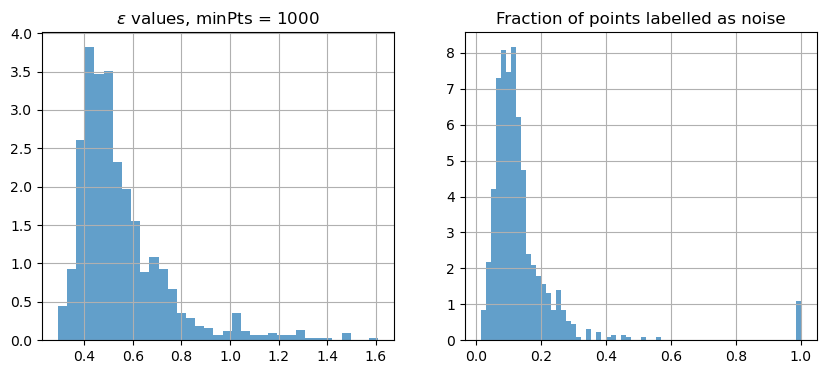

In [96]:
fig, ax = plt.subplots(ncols=2, figsize = [10,4])

ax[0].hist(eps_list, bins = "auto", alpha = 0.7, density = True)
ax[0].set_title("$\epsilon$ values, minPts = %d"%(minPts))
ax[0].grid()

ax[1].hist(err, bins = "auto", alpha = 0.7, density = True)
ax[1].set_title("Fraction of points labelled as noise")
ax[1].grid()

In [102]:
#chl_anomalies.time.to_numpy()[np.argwhere(err == 1.)]

#np.argwhere(err == 1.)

False